In [1]:

import os 
import pickle 
import evaluate_predictions
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import pstats
import re

datapath = "../data/efficiency_test/"

### Overview --  to be finishes




#### Compare ED predictions with/without coref, across data sets 

In [2]:
# load single data set 
path_predictions = f"{datapath}predictions/"
files = os.listdir(path_predictions)
predictions = {}

for f in files:
    with open(f"{path_predictions}{f}", "rb") as file:
        f = re.sub(".pickle", "", f)
        predictions[f] = pickle.load(file)

In [3]:
for version, d in predictions.items():
    # this only works for the aida test data sets 
    if "aida_test" in version:
        print(f"Evaluating predictions for {version}")
        evaluate_predictions.evaluate(d["predictions"])

Evaluating predictions for aida_testB_50_nocoref
Results: PMD RMD FMD PEL REL FEL: 97.4% 61.9% 75.7% | 65.7% 41.7% 51.0%
Evaluating predictions for aida_testB_500
Results: PMD RMD FMD PEL REL FEL: 97.9% 62.9% 76.6% | 62.1% 39.9% 48.6%
Evaluating predictions for aida_testB_500_nocoref
Results: PMD RMD FMD PEL REL FEL: 97.9% 62.9% 76.6% | 62.1% 39.9% 48.6%
Evaluating predictions for aida_testB_50
Results: PMD RMD FMD PEL REL FEL: 97.4% 61.8% 75.7% | 65.8% 41.7% 51.1%


#### Profile ED with/without coref, across data sets

In [4]:
path_profiling = f"{datapath}profile/"
files = os.listdir(path_profiling)
predictions = {}

for file in files:
    f = f"{path_profiling}{file}"
    d = pd.read_csv(f)
    file = re.sub(".csv", "", file)
    predictions[file] = d


In [6]:
d_list = []
# keep_strings = 'code object predict|code object with_coref'
keep_strings = 'predict|with_coref'

for filename, d in predictions.items():
    data = d.loc[d['fn'].str.contains(keep_strings), :].copy()
    data = data.loc[data['fn'] != 'predict', :]
    data['src'] = filename
    # data['func'] = np.where(data['fn'].str.contains('with_coref'), 'with_coref', 'predict')
    d_list.append(data)

df = pd.concat(d_list)



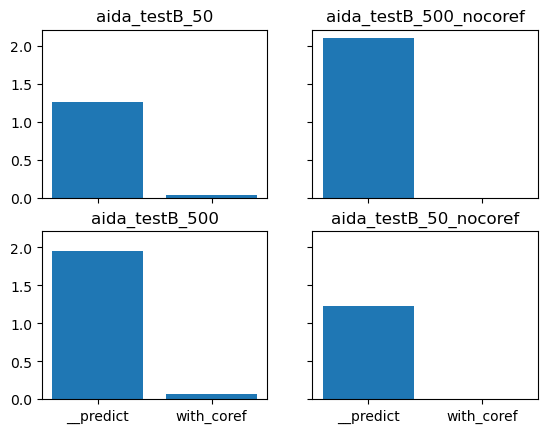

In [7]:
groups = df['src'].unique()
idxs = [[x, y] for x in range(2) for y in range(2)]

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

i = 0
for g in groups:
    dtemp = df.loc[df.src == g]
    col_idx = idxs[i][0]
    row_idx = idxs[i][1]
    x = dtemp['fn']
    y = dtemp['cumtime']
    axs[row_idx, col_idx].bar(x=x, height=y)
    axs[row_idx, col_idx].set_title(g)
    i += 1




- if this is so large, then still make the plot for the simulated large data!

#### Time complexity of entity disambiguation

In [8]:
time_dataset = {}
inputs = {
    "coref_yes": "",
    "coref_no": "_nocoref"
}
path_mentions_time = f"{datapath}n_mentions_time/"
for k, suffix in inputs.items():
    with open(f"{path_mentions_time}aida_testB{suffix}.pickle", "rb") as file:
        data = pickle.load(file)
        time_dataset[k] = data



In [9]:
time_dataset["coref_no"]["1163testb"].keys()
# time_dataset["coref_no"]["1163testb"]["profile"].head()

dict_keys(['n_mentions', 'time', 'profile'])

In [10]:

timing_overall = {}
for condition, conditiondata in time_dataset.items():
    d = []
    for docid, data in conditiondata.items():
        temp2 = {docid: {measure: value for measure, value in data.items() if measure in ["n_mentions", "time"]}}
        temp2 = pd.DataFrame.from_dict(temp2, orient="index")
        d.append(temp2)
    timing_overall[condition] = pd.concat(d)



Text(0, 0.5, 'time (seconds)')

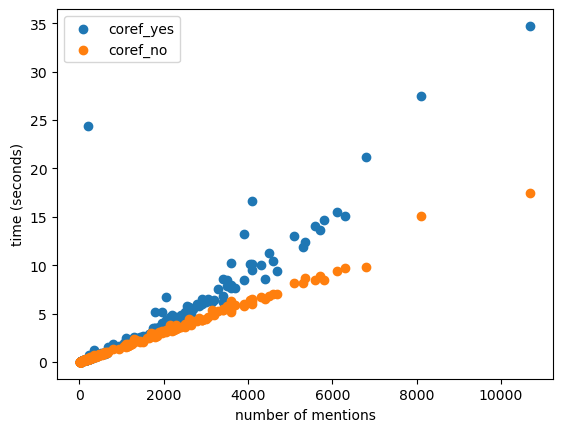

In [11]:
fig, ax = plt.subplots()

xs = [d['n_mentions'] for d in timing_overall.values()]
ys = [d['time'] for d in timing_overall.values()]

# x = [v["n_mentions", "time"] for v in time_dataset.values()]

for lbl, d in timing_overall.items():
    x = d['n_mentions']
    y = d['time']
    ax.scatter(x=x, y=y, label=lbl)

ax.legend()
ax.set_xlabel("number of mentions")
ax.set_ylabel("time (seconds)")


In [12]:
def filter_df(df, keep_strings, src):
    df = df.loc[df["fn"].str.contains(keep_strings), :].copy()
    df = df.loc[df['fn'] != "predict"] # predict calls with_coref, get_data_items, __predict
    df['src'] = src
    return df 

timing_profile = []
for condition, conditiondata in time_dataset.items():
    print(condition)
    d = []
    for docid, data in conditiondata.items():
        d_profile = filter_df(data["profile"], keep_strings=keep_strings, src=filename)
        d_profile['n_mentions'] = data['n_mentions']



        # temp2 = {docid: {measure: value for measure, value in data.items() if measure in ["n_mentions", "profile"]}}
        # temp2[docid]['profile'] = filter_df(temp2[docid]['profile'], keep_strings=keep_strings, src=filename)
        # temp2 = pd.DataFrame.from_dict(temp2, orient="index")
        d.append(d_profile)
    df_out = pd.concat(d)
    df_out['condition'] = condition
    timing_profile.append(df_out)
    
# do the same for the profiling output, process as above 
timing_profile = pd.concat(timing_profile)


coref_yes
coref_no


In [13]:
timing_profile.head()

,file,line,fn,cc,ncalls,tottime,cumtime,callers,src,n_mentions,condition
118,/home/flavio/projects/rel20/REL/src/REL/entity...,521,__predict,1,1,0.000380,0.018163,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_50_nocoref,39,coref_yes
168,/home/flavio/projects/rel20/REL/src/REL/traini...,108,with_coref,1,1,0.000019,0.000451,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_50_nocoref,39,coref_yes
119,/home/flavio/projects/rel20/REL/src/REL/entity...,521,__predict,1,1,0.047441,0.498564,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_50_nocoref,195,coref_yes
168,/home/flavio/projects/rel20/REL/src/REL/traini...,108,with_coref,1,1,0.000125,0.017074,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_50_nocoref,195,coref_yes
119,/home/flavio/projects/rel20/REL/src/REL/entity...,521,__predict,1,1,0.109560,0.649034,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_50_nocoref,390,coref_yes


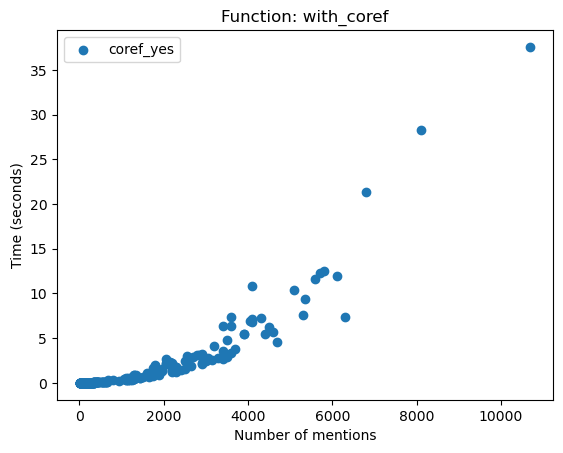

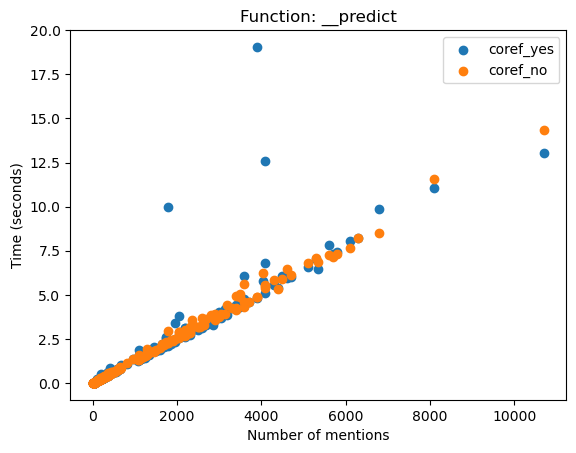

In [14]:

xlabel = 'Number of mentions'
ylabel = 'Time (seconds)'

for fnc in ['with_coref', '__predict']:
    fig, ax = plt.subplots()

    dtemp = timing_profile.loc[timing_profile['fn'] == fnc, :] # plot the timing for the function predict 
    conditions = dtemp['condition'].unique()

    for c in conditions:
        d = dtemp.loc[dtemp['condition'] == c, :]
        ax.scatter(x=d['n_mentions'], y=d['cumtime'], label=c)
        


    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"Function: {fnc}")




Text(0.5, 1.0, 'Comparing function timing when coref is on')

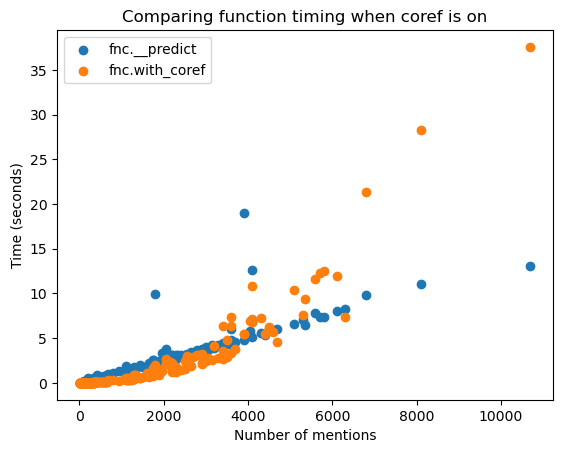

In [15]:
fig, ax = plt.subplots()
dtemp = timing_profile.loc[timing_profile['condition'] == "coref_yes", :]
functions = ['__predict', 'with_coref']

for fn in functions:
    fn_label = f"fnc.{fn}"
    d = dtemp.loc[dtemp['fn'] == fn, :]
    ax.scatter(x=d['n_mentions'], y=d['cumtime'], label=fn_label)


ax.legend()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title("Comparing function timing when coref is on")

## What is going on?
- with_coref grows quadratically, that is expected 
- time for __predict does not depend on whether we use with_coref or not 
- the overhead of predict is quite large, only at around 4000 mentions the with_coref effects dominates 

,identifier,field,text,start_pos,end_pos,score,tag
0,msmarco_doc_00_0,2,United States,807,820,0.999501,LOC
1,msmarco_doc_00_0,2,United States,1206,1219,0.999599,LOC
2,msmarco_doc_00_0,2,Exotic,1491,1497,0.663401,MISC
3,msmarco_doc_00_0,2,BMW M3,3762,3768,0.675480,MISC
4,msmarco_doc_00_0,2,Corvette Z06,3822,3834,0.801726,MISC
